<a href="https://colab.research.google.com/github/klaasmeinke/CNNs-exoplanet-cartography/blob/main/NN_Rot_Axis_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Thesis'

%run Create_Data.ipynb

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K

keras.backend.set_floatx('float32')
print("num GPUs Avilable: ", len(tf.config.experimental.list_physical_devices('GPU')))

Mounted at /content/drive
/content/drive/MyDrive/Thesis
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Thesis
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Thesis
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Thesis
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Thesis
num GPUs Avilable:  0


#### Periodic Convolutions

In [ ]:
def conv_curves(x, kernel_size = 1, filters = 1, activation = None, stride = 1):
    idx = tf.constant(list(range(8)) + list(range(kernel_size - 1)))

    x = Lambda(lambda x: tf.gather(x, idx, axis = 2))(x)
    x = Conv2D(filters = filters, kernel_size = (1, kernel_size),
               padding = 'valid', activation = activation,
               strides = (1,stride))(x)

    return x

#### Create Model

In [ ]:
def create_model(polarization = True):
    if polarization:
        input_shape = (8,8,12)
    else:
        input_shape = (8,8,6)

    # # CREATE MODEL
    c0 = keras.Input(shape = input_shape, name = 'curves_input')

    c10 = conv_curves(c0, kernel_size = 3, filters = 16)
    c20 = conv_curves(c10, kernel_size = 4, filters = 16, stride = 2)

    c30 = Flatten()(c20)

    x10 = Dense(512)(c30)
    x11 = PReLU()(x10)
    x12 = Dropout(0.15)(x11)

    x20 = Dense(512)(x12)
    x21 = PReLU()(x20)
    x22 = Dropout(0.15)(x21)

    x30 = Dense(256)(x22)
    x31 = PReLU()(x30)
    x32 = Dropout(0.15)(x31)

    x60 = Dense(32)(x32)
    x61 = PReLU()(x60)

    x7 = Dense(3, name = 'final')(x61)
    # make sure the output has a norm of 1
    # x8 = Lambda(lambda  x: K.l2_normalize(x, axis=1))(x7)

    model = keras.Model(
        inputs=[c0],
        outputs=[x7],
    )

    model.compile(optimizer = 'adam', loss='mse')
    model.summary()

    return model

#### Load Data:

In [ ]:
load_data(i = 0, axis_idx = range(32), flatten = False, maps = False,
          fourier = False, polarization = False)

curves:  (286213, 8, 8, 6)
combos:  (286213, 4)
axes:    (286213, 3)


# Testing Degeneracy

In [ ]:
def signedVolume(a, b, c, d):
    """Computes the signed volume of a series of tetrahedrons defined by the vertices in
    a, b c and d. The ouput is an SxT array which gives the signed volume of the tetrahedron defined
    by the line segment 's' and two vertices of the triangle 't'."""

    return np.sum((a-d)*np.cross(b-d, c-d), axis=2)

def segmentsIntersectTriangles(s, t):
    """For each line segment in 's', this function computes whether it intersects any of the triangles
    given in 't'."""
    # compute the normals to each triangle
    normals = np.cross(t[2]-t[0], t[2]-t[1])
    normals /= np.linalg.norm(normals, axis=1)[:, np.newaxis]

    # get sign of each segment endpoint, if the sign changes then we know this segment crosses the
    # plane which contains a triangle. If the value is zero the endpoint of the segment lies on the
    # plane.
    # s[i][:, np.newaxis] - t[j] -> S x T x 3 array
    sign1 = np.sign(np.sum(normals*(s[0][:, np.newaxis] - t[2]), axis=2)) # S x T
    sign2 = np.sign(np.sum(normals*(s[1][:, np.newaxis] - t[2]), axis=2)) # S x T

    # determine segments which cross the plane of a triangle. 1 if the sign of the end points of s is
    # different AND one of end points of s is not a vertex of t
    cross = (sign1 != sign2)*(sign1 != 0)*(sign2 != 0) # S x T

    # get signed volumes
    v1 = np.sign(signedVolume(t[0], t[1], s[0][:, np.newaxis], s[1][:, np.newaxis])) # S x T
    v2 = np.sign(signedVolume(t[1], t[2], s[0][:, np.newaxis], s[1][:, np.newaxis])) # S x T
    v3 = np.sign(signedVolume(t[2], t[0], s[0][:, np.newaxis], s[1][:, np.newaxis])) # S x T

    same_volume = np.logical_and((v1 == v2), (v2 == v3)) # 1 if s and t have same sign in v1, v2 and v3

    return cross*same_volume

In [ ]:
def flip(albedos, norm):
    faces = np.load('data/faces.npy')
    t = np.vstack(([faces[:,0,:]],[faces[:,1,:]],[faces[:,2,:]]))

    norm = np.array(norm)
    norm = 6 * norm/np.linalg.norm(norm) # the norm have a mag of 3 so it passes through the entire sphere

    points = np.load('data/points.npy')
    s = [[],[]]
    for point in points:
        if np.dot(point, norm) > 0: # in the same direction
            begin = point - 1e-9 * norm
            end = point - norm
        else:
            begin = point + 1e-9 * norm
            end = point + norm
        s[0].append(begin)
        s[1].append(end)

    s = np.array(s)
    x = segmentsIntersectTriangles(s, t)
    new_albedos = []

    for i in range(1000):
        if sum(x[i]) == 1:
            new_albedos.append(albedos[np.argmax(x[i])])
        elif sum(x[i]) == 0:
            new_albedos.append(albedos[i])

    return np.array(new_albedos)

Original


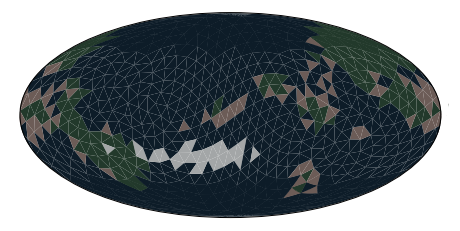

Degenerate


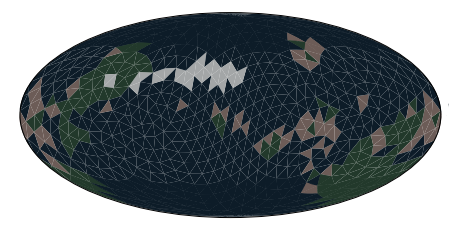

In [ ]:
# map1 = combine(surfaces[4572], clouds[7694])
# # map1 = surfaces[4572]
# map2 = flip(map1, [0,0,1])

# faces = np.load('data/faces.npy')
# # PLOTTING
# print('Original')
# mollweide(faces, map1)
# plt.show()
# print('Degenerate')
# mollweide(faces, map2)
# plt.show()

original axis: [ 0.93251189 -0.2047371  -0.29749673]
degenerate: [-0.93251189  0.2047371  -0.29749673]


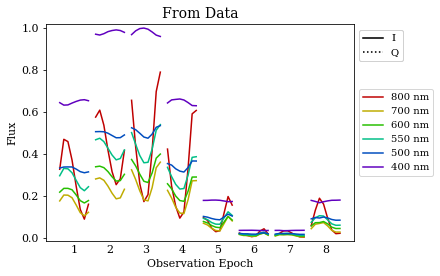

[0.013245 0.00904  0.01164  0.015274 0.01831  0.03592 ]


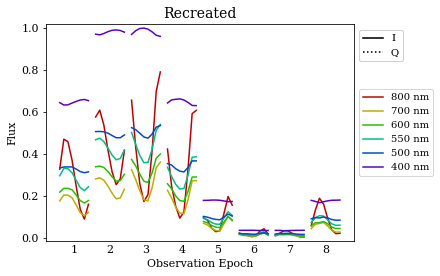

[0.01325  0.00905  0.01164  0.015274 0.01833  0.03592 ]


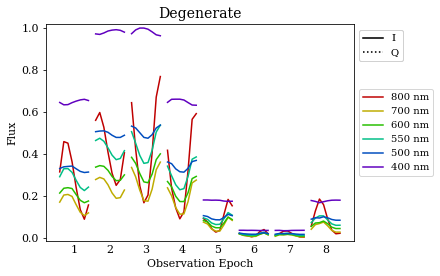

[0.01253  0.007996 0.010765 0.01465  0.01782  0.03595 ]


In [ ]:
# axis1 = np.load('data/axes.npy')[57]
# axis2 = axis1 * np.array([-1,-1,1])

# print('original axis: ' + str(axis1))
# print('degenerate: ' + str(axis2))

# rot_phases = np.linspace(0, 2*np.pi, 8, endpoint = False)

# rot_norms1 = norm_rotation(np.load('data/norms.npy'), axis1, rot_phases)
# rot_norms2 = norm_rotation(np.load('data/norms.npy'), axis2, rot_phases)

# curves1 = orbit_fluxes(rot_norms1, map1, 0, fourier = False)
# curves2 = orbit_fluxes(rot_norms2, map2, 0, fourier = False)
# curves1 = curves1/np.max(curves1)
# curves2 = curves2/np.max(curves2)

# # PLOT
# plot_fluxes(curves[-1,:,:,:], figsize = (6.5,4))
# # plot_fluxes(curves[-1,:,:,1::2], new_fig = False, linestyle='dotted')
# plt.ylim([np.min(curves[-1]) - 0.02, np.max(curves[-1]) + 0.02])
# add_legend(labels = ['I', 'Q'], y = 0.9)
# plt.title('From Data')
# plt.show()
# print(np.float16(curves[-1,6,0]))

# plot_fluxes(curves1[:,:,:], figsize = (6.5,4))
# # plot_fluxes(curves1[:,:,:,1], new_fig = False, linestyle='dotted')
# plt.ylim([np.min(curves1) - 0.02, np.max(curves1) + 0.02])
# add_legend(labels = ['I', 'Q'], y = 0.9)
# plt.title('Recreated')
# plt.show()
# print(curves1[6,0])

# plot_fluxes(curves2[:,:,:], figsize = (6.5,4))
# # plot_fluxes(curves2[:,:,:,1], new_fig = False, linestyle='dotted')
# plt.ylim([np.min(curves2) - 0.02, np.max(curves2) + 0.02])
# add_legend(labels = ['I', 'Q'], y = 0.9)
# plt.title('Degenerate')
# plt.show()
# print(curves2[6,0])

Original


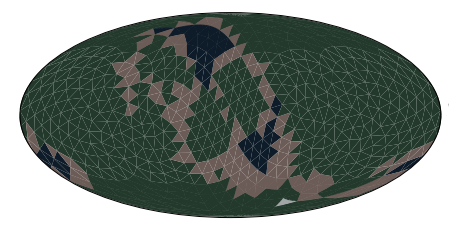

Degenerate


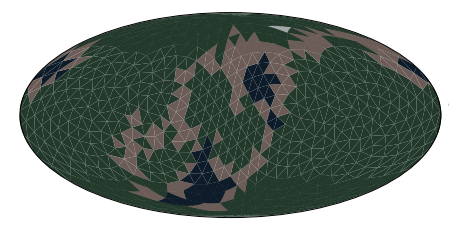

In [ ]:
# map1 = combine(surfaces[3963], clouds[3457])
# # map1 = np.load('data/earth_surface_types')
# map2 = flip(map1, [0,0,1])

# faces = np.load('data/faces.npy')
# # PLOTTING
# print('Original')
# mollweide(faces, map1)
# plt.show()
# print('Degenerate')
# mollweide(faces, map2)
# plt.show()

original axis: [-0.68277416  0.61421131 -0.39568158]
degenerate: [ 0.68277416 -0.61421131 -0.39568158]


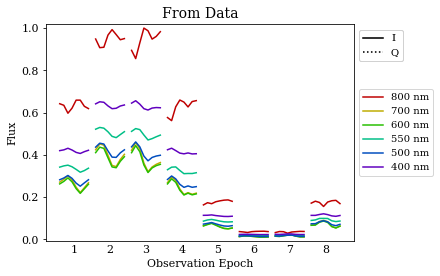

[0.0313   0.01419  0.013916 0.01772  0.015205 0.02303 ]


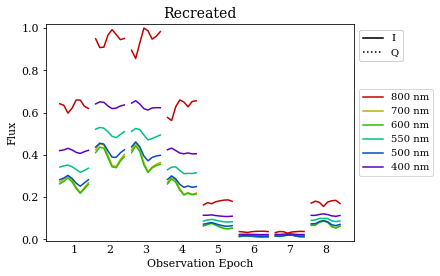

[0.0313   0.014206 0.01393  0.01772  0.015205 0.02304 ]


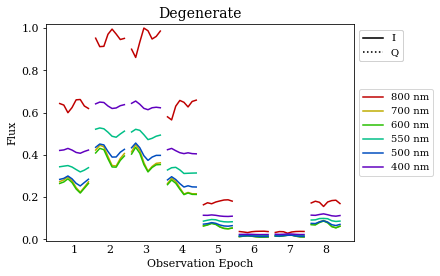

[0.0319  0.01468 0.01435 0.01813 0.01556 0.02335]


In [ ]:
# axis1 = np.load('data/axes.npy')[12]
# axis2 = axis1 * np.array([-1,-1,1])

# print('original axis: ' + str(axis1))
# print('degenerate: ' + str(axis2))

# rot_phases = np.linspace(0, 2*np.pi, 8, endpoint = False)

# rot_norms1 = norm_rotation(np.load('data/norms.npy'), axis1, rot_phases)
# rot_norms2 = norm_rotation(np.load('data/norms.npy'), axis2, rot_phases)

# curves1 = orbit_fluxes(rot_norms1, map1, 0, fourier = False)
# curves2 = orbit_fluxes(rot_norms2, map2, 0, fourier = False)
# curves1 = curves1/np.max(curves1)
# curves2 = curves2/np.max(curves2)

# # PLOT
# plot_fluxes(curves[-2,:,:,:], figsize = (6.5,4))
# # plot_fluxes(curves[-1,:,:,1::2], new_fig = False, linestyle='dotted')
# plt.ylim([np.min(curves[-2]) - 0.02, np.max(curves[-2]) + 0.02])
# add_legend(labels = ['I', 'Q'], y = 0.9)
# plt.title('From Data')
# plt.show()
# print(np.float16(curves[-2,6,0]))

# plot_fluxes(curves1[:,:,:], figsize = (6.5,4))
# # plot_fluxes(curves1[:,:,:,1], new_fig = False, linestyle='dotted')
# plt.ylim([np.min(curves1) - 0.02, np.max(curves1) + 0.02])
# add_legend(labels = ['I', 'Q'], y = 0.9)
# plt.title('Recreated')
# plt.show()
# print(curves1[6,0])

# plot_fluxes(curves2[:,:,:], figsize = (6.5,4))
# # plot_fluxes(curves2[:,:,:,1], new_fig = False, linestyle='dotted')
# plt.ylim([np.min(curves2) - 0.02, np.max(curves2) + 0.02])
# add_legend(labels = ['I', 'Q'], y = 0.9)
# plt.title('Degenerate')
# plt.show()
# print(curves2[6,0])

In [ ]:
# print('predictions (original, recreated, degenerate)')
# print()

# print(model.predict(np.array([curves[-2],
#                               curves1,
#                               curves2])))

predictions (original, recreated, degenerate)

[[-0.4673947   0.29837152 -0.436105  ]
 [-0.57493496  0.42940718 -0.45131326]
 [ 0.7120707  -0.6288627  -0.36856735]]


Original


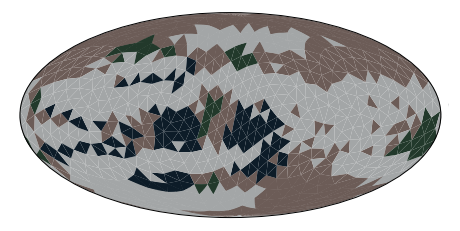

Degenerate


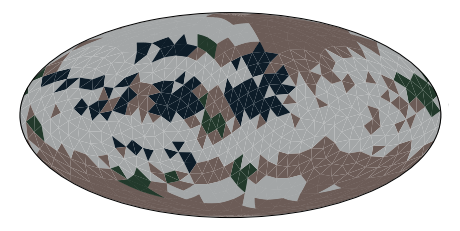

In [ ]:
# map1 = combine(surfaces[9864], clouds[7733])
# # map1 = np.load('data/earth_surface_types')
# map2 = flip(map1, [0,0,1])

# faces = np.load('data/faces.npy')
# # PLOTTING
# print('Original')
# mollweide(faces, map1)
# plt.show()
# print('Degenerate')
# mollweide(faces, map2)
# plt.show()

original axis: [ 0.31186259  0.67720734 -0.66643225]
degenerate: [-0.31186259 -0.67720734 -0.66643225]


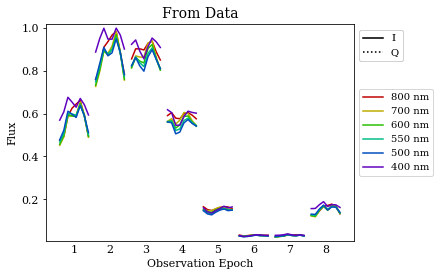

[0.02406 0.02356 0.02414 0.0249  0.02583 0.0315 ]


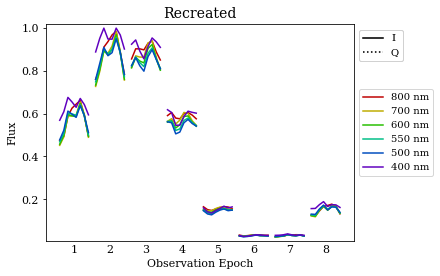

[0.02408 0.02356 0.02414 0.0249  0.02583 0.0315 ]


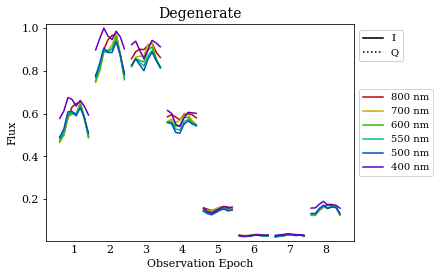

[0.02365 0.0228  0.02335 0.02415 0.02502 0.03082]


In [ ]:
# axis1 = np.load('data/axes.npy')[10]
# axis2 = axis1 * np.array([-1,-1,1])

# print('original axis: ' + str(axis1))
# print('degenerate: ' + str(axis2))

# rot_phases = np.linspace(0, 2*np.pi, 8, endpoint = False)

# rot_norms1 = norm_rotation(np.load('data/norms.npy'), axis1, rot_phases)
# rot_norms2 = norm_rotation(np.load('data/norms.npy'), axis2, rot_phases)

# curves1 = orbit_fluxes(rot_norms1, map1, 0, fourier = False)
# curves2 = orbit_fluxes(rot_norms2, map2, 0, fourier = False)
# curves1 = curves1/np.max(curves1)
# curves2 = curves2/np.max(curves2)

# # PLOT
# plot_fluxes(curves[-3,:,:,:], figsize = (6.5,4))
# # plot_fluxes(curves[-1,:,:,1::2], new_fig = False, linestyle='dotted')
# plt.ylim([np.min(curves[-3]) - 0.02, np.max(curves[-3]) + 0.02])
# add_legend(labels = ['I', 'Q'], y = 0.9)
# plt.title('From Data')
# plt.show()
# print(np.float16(curves[-3,6,0]))

# plot_fluxes(curves1[:,:,:], figsize = (6.5,4))
# # plot_fluxes(curves1[:,:,:,1], new_fig = False, linestyle='dotted')
# plt.ylim([np.min(curves1) - 0.02, np.max(curves1) + 0.02])
# add_legend(labels = ['I', 'Q'], y = 0.9)
# plt.title('Recreated')
# plt.show()
# print(curves1[6,0])

# plot_fluxes(curves2[:,:,:], figsize = (6.5,4))
# # plot_fluxes(curves2[:,:,:,1], new_fig = False, linestyle='dotted')
# plt.ylim([np.min(curves2) - 0.02, np.max(curves2) + 0.02])
# add_legend(labels = ['I', 'Q'], y = 0.9)
# plt.title('Degenerate')
# plt.show()
# print(curves2[6,0])

Original


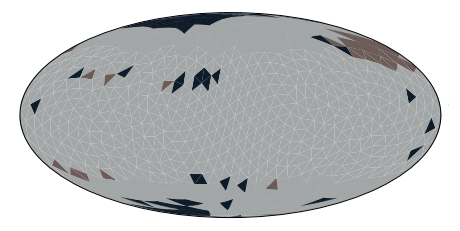

Degenerate


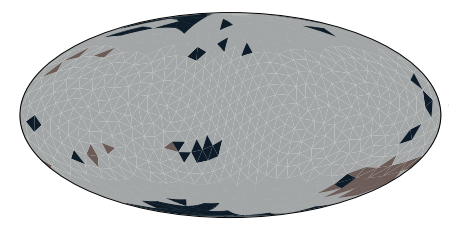

In [ ]:
# map1 = combine(surfaces[5903], clouds[7604])
# # map1 = np.load('data/earth_surface_types')
# map2 = flip(map1, [0,0,1])

# faces = np.load('data/faces.npy')
# # PLOTTING
# print('Original')
# mollweide(faces, map1)
# plt.show()
# print('Degenerate')
# mollweide(faces, map2)
# plt.show()

original axis: [-0.78324714  0.29923115  0.54496296]
degenerate: [ 0.78324714 -0.29923115  0.54496296]


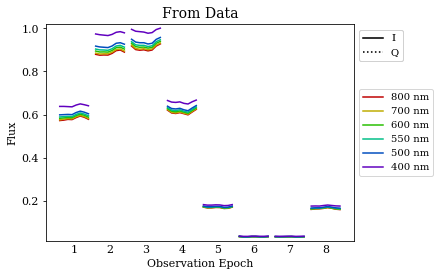

[0.5723 0.5757 0.5825 0.589  0.5986 0.6377]


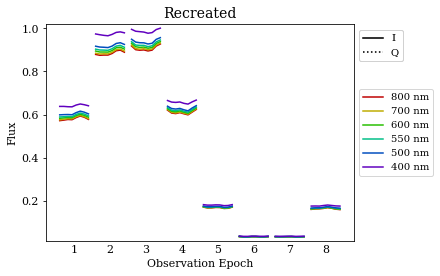

[0.572  0.5757 0.5825 0.589  0.5986 0.6377]


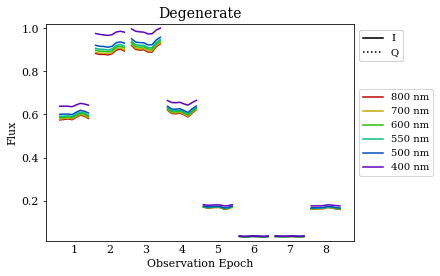

[0.5747 0.578  0.585  0.5913 0.6006 0.638 ]


In [ ]:
# axis1 = np.load('data/axes.npy')[22]
# axis2 = axis1 * np.array([-1,-1,1])

# print('original axis: ' + str(axis1))
# print('degenerate: ' + str(axis2))

# rot_phases = np.linspace(0, 2*np.pi, 8, endpoint = False)

# rot_norms1 = norm_rotation(np.load('data/norms.npy'), axis1, rot_phases)
# rot_norms2 = norm_rotation(np.load('data/norms.npy'), axis2, rot_phases)

# curves1 = orbit_fluxes(rot_norms1, map1, 0, fourier = False)
# curves2 = orbit_fluxes(rot_norms2, map2, 0, fourier = False)
# curves1 = curves1/np.max(curves1)
# curves2 = curves2/np.max(curves2)

# # PLOT
# plot_fluxes(curves[-4,:,:,:], figsize = (6.5,4))
# # plot_fluxes(curves[-1,:,:,1::2], new_fig = False, linestyle='dotted')
# plt.ylim([np.min(curves[-4]) - 0.02, np.max(curves[-4]) + 0.02])
# add_legend(labels = ['I', 'Q'], y = 0.9)
# plt.title('From Data')
# plt.show()
# print(np.float16(curves[-4,0,0]))

# plot_fluxes(curves1[:,:,:], figsize = (6.5,4))
# # plot_fluxes(curves1[:,:,:,1], new_fig = False, linestyle='dotted')
# plt.ylim([np.min(curves1) - 0.02, np.max(curves1) + 0.02])
# add_legend(labels = ['I', 'Q'], y = 0.9)
# plt.title('Recreated')
# plt.show()
# print(curves1[0,0])

# plot_fluxes(curves2[:,:,:], figsize = (6.5,4))
# # plot_fluxes(curves2[:,:,:,1], new_fig = False, linestyle='dotted')
# plt.ylim([np.min(curves2) - 0.02, np.max(curves2) + 0.02])
# add_legend(labels = ['I', 'Q'], y = 0.9)
# plt.title('Degenerate')
# plt.show()
# print(curves2[0,0])

# Scatter Plots:

In [ ]:
def scatter_plots(axes, pred):
    axis_labels = ['X','Y','Z']
    for i in range(3):

        fig = plt.figure(figsize = (3,3), dpi = 150)
        fig.set_facecolor('white')
        # plt.grid()

        # plt.title(axis_labels[i]+' Axis')
        plt.text(-0.97, 0.89, 'N = '+str(len(axes)))
        plt.text(-0.97, 0.75,'MSE = ' + str(round(np.mean((pred[:,i]-axes[:,i])**2), 4)))

        plt.xlabel('actual')
        plt.ylabel('predicted')

        plt.scatter(axes[:,i],pred[:,i], marker='x', linewidth = 0.8,
                    color = '#1f829a')
        plt.plot([-1, 1], [-1, 1], color = 'gray', linewidth = 2,
                 linestyle = 'dotted')

        plt.xlim([-1.05, 1.05])
        plt.ylim([-1.05, 1.05])

        plt.yticks([-1, -0.5, 0, 0.5, 1])
        plt.xticks([-1, -0.5, 0, 0.5, 1])

        # norm = mcolors.Normalize(vmin=0, vmax=90)
        # cmap = plt.cm.winter
        # sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        # plt.colorbar(sm, label='inclination [deg]')

curves:  (286213, 8, 8, 12)
combos:  (286213, 4)
axes:    (286213, 3)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 curves_input (InputLayer)   [(None, 8, 8, 12)]        0         
                                                                 
 lambda (Lambda)             (None, 8, 10, 12)         0         
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 16)          592       
                                                                 
 lambda_1 (Lambda)           (None, 8, 11, 16)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 4, 16)          1040      
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                         

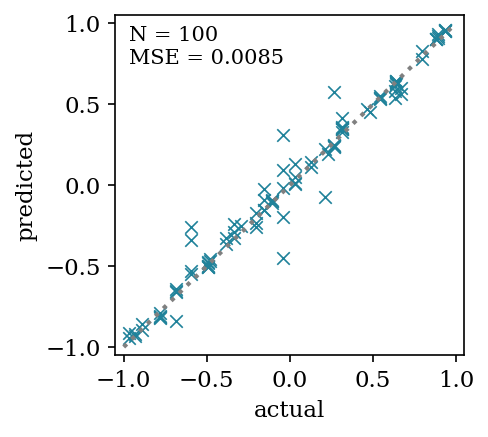

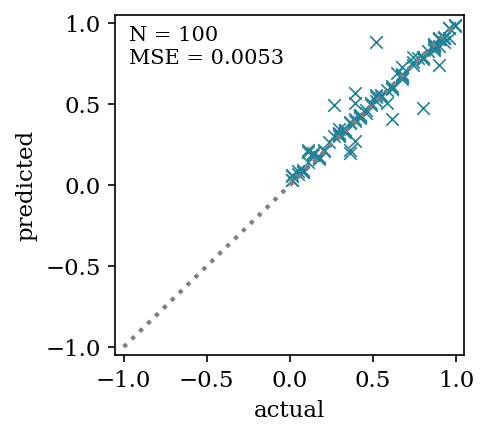

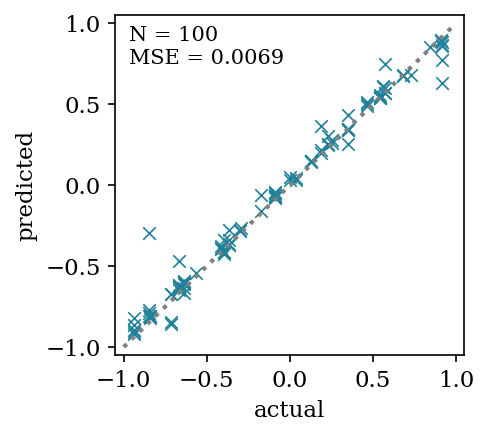

In [ ]:
# THESE ARE FOR THE PRESENTATION!

load_data(i = 0, axis_idx = range(32), flatten = False, maps = False,
          fourier = True, polarization = True)


model = create_model(polarization = True)
model.load_weights('models/rot_axis/i0_fou_pol_32.h5')

N = 100
val_axes = axes[-N:]
val_combos = combos[-N:]
val_curves = curves[-N:]

pred = model.predict([val_curves])

scatter_plots(val_axes, pred)

### Side-On Orbit with Different Noise Levels

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
curves_input (InputLayer)    [(None, 8, 8, 12)]        0         
_________________________________________________________________
lambda (Lambda)              (None, 8, 10, 12)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 16)          592       
_________________________________________________________________
lambda_1 (Lambda)            (None, 8, 11, 16)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 4, 16)          1040      
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656

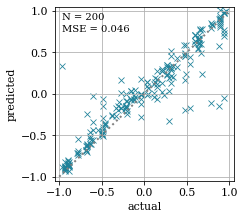

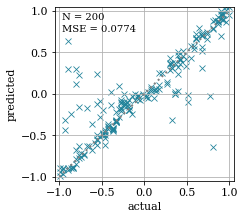

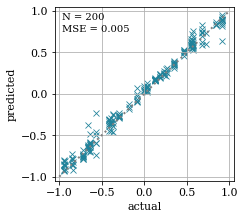

100000.0
curves:  (572008, 8, 8, 12)
combos:  (572008, 4)
axes:    (572008, 3)
Epoch 1/100
4022/4022 [==============================] - 18s 4ms/step - loss: 0.1897 - val_loss: 0.1910
Epoch 2/100
4022/4022 [==============================] - 17s 4ms/step - loss: 0.1829 - val_loss: 0.1855
Epoch 3/100
4022/4022 [==============================] - 17s 4ms/step - loss: 0.1779 - val_loss: 0.1821
Epoch 4/100
4022/4022 [==============================] - 17s 4ms/step - loss: 0.1736 - val_loss: 0.1801
Epoch 5/100
4022/4022 [==============================] - 17s 4ms/step - loss: 0.1697 - val_loss: 0.1768
Epoch 6/100
4022/4022 [==============================] - 17s 4ms/step - loss: 0.1664 - val_loss: 0.1749
Epoch 7/100
4022/4022 [==============================] - 17s 4ms/step - loss: 0.1631 - val_loss: 0.1716
Epoch 8/100
4022/4022 [==============================] - 17s 4ms/step - loss: 0.1600 - val_loss: 0.1693
Epoch 9/100
4022/4022 [==============================] - 17s 4ms/step - loss: 0.1573 - va

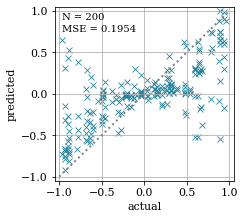

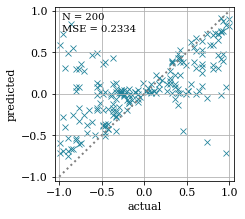

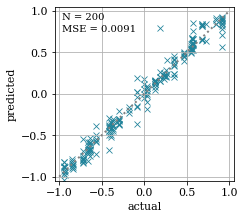

10000.0
curves:  (572008, 8, 8, 12)
combos:  (572008, 4)
axes:    (572008, 3)
mean error:  0.21971823906698537


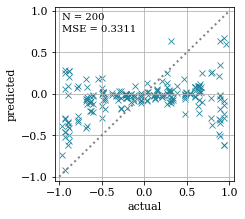

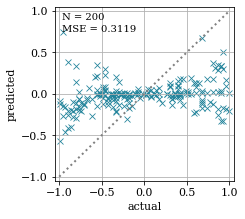

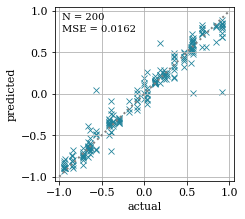

1000.0
curves:  (572008, 8, 8, 12)
combos:  (572008, 4)
axes:    (572008, 3)
Epoch 1/100
4022/4022 [==============================] - 18s 5ms/step - loss: 0.2339 - val_loss: 0.2329
Epoch 2/100
4022/4022 [==============================] - 18s 4ms/step - loss: 0.2304 - val_loss: 0.2329
Epoch 3/100
4022/4022 [==============================] - 18s 4ms/step - loss: 0.2278 - val_loss: 0.2321
Epoch 4/100
4022/4022 [==============================] - 18s 4ms/step - loss: 0.2255 - val_loss: 0.2330
Epoch 5/100
4022/4022 [==============================] - 18s 4ms/step - loss: 0.2230 - val_loss: 0.2332
mean error:  0.2296543431491775


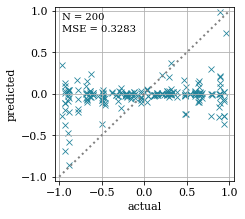

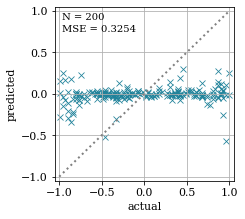

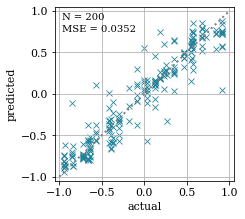

In [ ]:
# LOAD DATA

model = create_model(polarization = True)

for N_max in [1e6, 1e5, 1e4, 1e3]:

    print(N_max)

    load_data(i = 0, axis_idx = range(64), flatten = False, maps = False,
        fourier = True, polarization = True, N_max = N_max,
        norm = True)

    model.load_weights('models/rot_axis/i0_fou_pol_64.h5')

    if N_max != 1e4:
        model.fit(
            curves,
            axes,
            epochs = 100,
            batch_size = 128,
            validation_split = 0.1,
            callbacks=[keras.callbacks.EarlyStopping(patience = 2)]
        )

    N = 200
    val_axes = axes[-N:]
    val_combos = combos[-N:]
    val_curves = curves[-N:]

    pred = model.predict([val_curves])

    print('mean error: ', np.mean((val_axes-pred)**2))

    scatter_plots(val_axes, pred)
    plt.show()

### Side-On Orbit with Constrained Axis

mean error:  0.011749314140432968


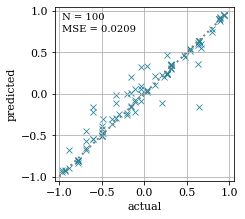

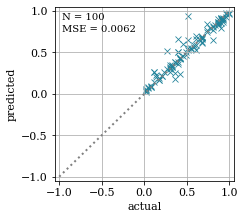

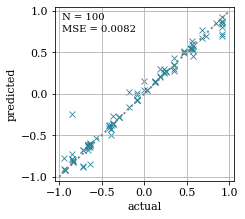

In [ ]:
# LOAD DATA

# model = create_model(polarization = True)
# model.load_weights('models/rot_axis/i0_fou_pol_32.h5')

# N_max = 1e4

# load_data(i = 0, axis_idx = range(32), flatten = False, maps = False,
#     fourier = True, polarization = True, N_max = N_max,
#     norm = True)

# model.fit(
#     curves,
#     axes,
#     epochs = 100,
#     batch_size = 128,
#     validation_split = 0.1,
#     callbacks=[keras.callbacks.EarlyStopping(patience = 2)]
# )

N = 100
val_axes = axes[-N:]
val_combos = combos[-N:]
val_curves = curves[-N:]

pred = model.predict([val_curves])

print('mean error: ', np.mean((val_axes-pred)**2))

scatter_plots(val_axes, pred)
plt.show()

# Plot Inclination Losses

In [ ]:
lamb_lamb_64 = [0.22465761, 0.03986305, 0.01659222, 0.01251739, 0.00970021, 0.00797684, 0.00749984]
lamb_fou_64 = [0.34204975, 0.3647539, 0.26779166, 0.13017614, 0.03851768, 0.01664315, 0.01167843]
fou_64 = [0.21875241, 0.05845854, 0.02654507, 0.01813591, 0.01305945, 0.01105049, 0.00993716]
fou_pol_64 = [0.21419777, 0.04435654, 0.01969129, 0.01450622, 0.01168167, 0.01083235, 0.00971964]

print(np.min([lamb_fou_64, fou_64, fou_pol_64]))

0.00971964


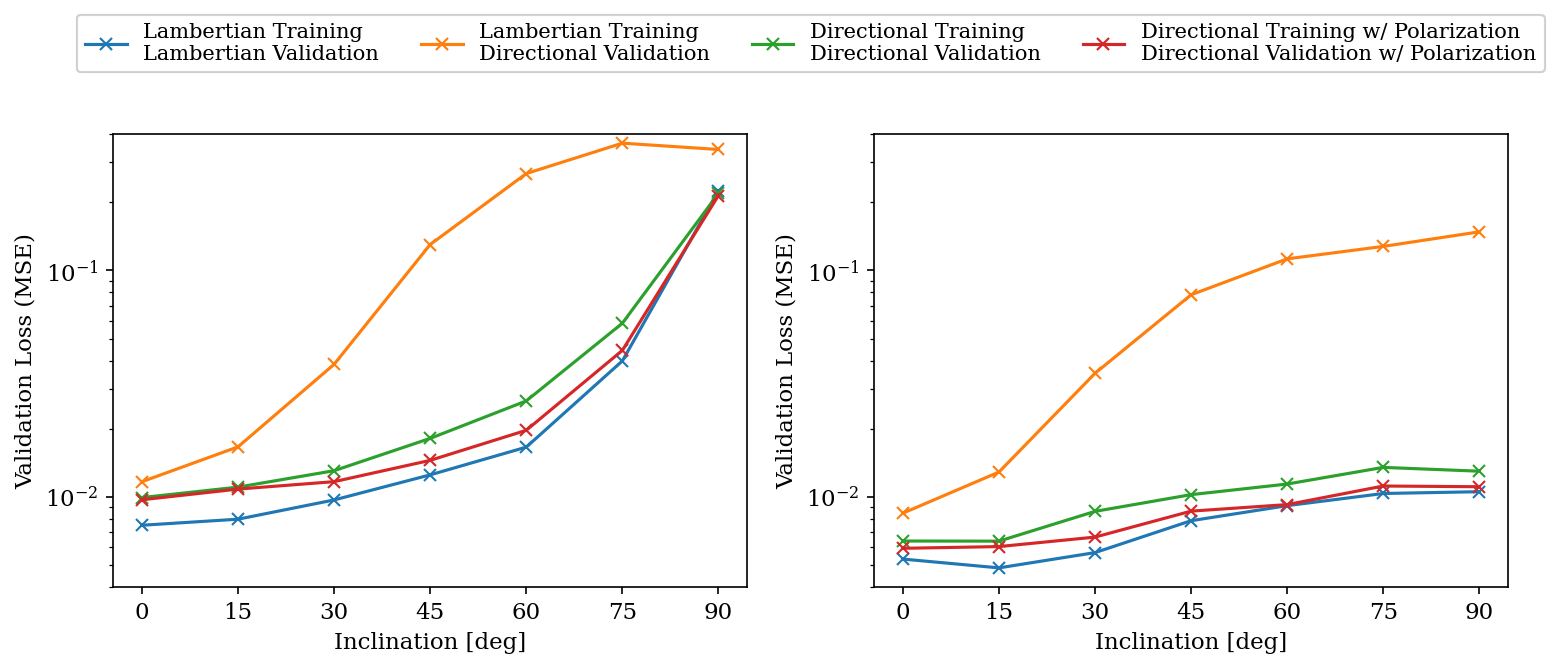

In [ ]:
lamb_lamb_32 = [0.0105484, 0.01035779, 0.00915396, 0.00785475, 0.0056788,  0.0048628, 0.00531725]
lamb_fou_32 = [0.14807586, 0.12769404, 0.11251273, 0.07809155, 0.03514491, 0.01288211, 0.00847912]
fou_32 = [0.01299226, 0.01350626, 0.01140377, 0.01023794, 0.0086366, 0.00638058, 0.00638911]
fou_pol_32 = [0.01109452, 0.01117598, 0.00925178, 0.00865738, 0.0066488, 0.00603712, 0.00593353]

lamb_lamb_64 = [0.22465761, 0.03986305, 0.01659222, 0.01251739, 0.00970021, 0.00797684, 0.00749984]
lamb_fou_64 = [0.34204975, 0.3647539, 0.26779166, 0.13017614, 0.03851768, 0.01664315, 0.01167843]
fou_64 = [0.21875241, 0.05845854, 0.02654507, 0.01813591, 0.01305945, 0.01105049, 0.00993716]
fou_pol_64 = [0.21419777, 0.04435654, 0.01969129, 0.01450622, 0.01168167, 0.01083235, 0.00971964]

incls = [0,15,30,45,60,75,90]

# fig, ax = plt.subplots(figsize = (7,5), dpi = 120)
# plt.plot(incls, lamb_lamb_32, 'x-', color = 'tab:blue',
#          label = 'Lambertian Model w/\nLambertian Data')
# plt.plot(incls, lamb_fou_32, 'x-', color = 'tab:orange',
#          label = 'Lambertian Model w/\nDirectional Data')
# plt.plot(incls, fou_32, 'x-', color = 'tab:green',
#          label = 'Directional Model')
# plt.plot(incls, fou_pol_32, 'x-', color = 'tab:red',
#          label = 'Directional Model w/\nPolarization')

# plt.ylim([0.005, 0.17])

# plt.plot(incls, lamb_lamb_64, 'x-', color = 'tab:blue', linestyle = 'dotted')
# plt.plot(incls, lamb_fou_64, 'x-', color = 'tab:orange', linestyle = 'dotted')
# plt.plot(incls, fou_64, 'x-', color = 'tab:green', linestyle = 'dotted')
# plt.plot(incls, fou_pol_64, 'x-', color = 'tab:red', linestyle = 'dotted')

# plt.plot(incls, fou_32, 'x-', label = 'Directional Reflection')
# plt.plot(incls, fou_pol_32, 'x-', label = 'Directional Reflection with Polarization')

# legend0 = plt.legend()
# plt.gca().add_artist(legend0)

# plt.xlabel('Inclination [deg]')
# plt.ylabel('Validation Loss (MSE)')
# plt.yscale('log')
# ax.tick_params(axis='y', which='both')
# plt.grid(which = 'major', color = [0.8,0.8,0.8])
# plt.grid(which = 'minor', color = [0.9,0.9,0.9], axis = 'y')
# plt.xticks(incls, ['0\nSide-On Orbit', '15', '30', '45', '60', '75',
#                    '90\nFace-On Orbit'])

# add_legend(linestyles=['solid', 'dotted'], loc = 'center right', y = 0.7,
#            labels = ['$\;\;\; 0 \leq y_{rot} \leq 1$', '$-1\leq y_{rot} \leq 1$'])

# plt.xticks(incls)
# plt.show()

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,4), dpi = 150, facecolor = 'white')

for ax, lamb_lamb, lamb_fou, fou, fou_pol in zip([ax1, ax2],
                                              [lamb_lamb_64, lamb_lamb_32],
                                              [lamb_fou_64, lamb_fou_32],
                                              [fou_64, fou_32],
                                              [fou_pol_64, fou_pol_32]):

    ax.plot(incls, lamb_lamb[::-1], 'x-', color = 'tab:blue',
            label = 'Lambertian Training\nLambertian Validation')
    ax.plot(incls, lamb_fou[::-1], 'x-', color = 'tab:orange',
            label = 'Lambertian Training\nDirectional Validation')
    ax.plot(incls, fou[::-1], 'x-', color = 'tab:green',
            label = 'Directional Training\nDirectional Validation')
    ax.plot(incls, fou_pol[::-1], 'x-', color = 'tab:red',
            label = 'Directional Training w/ Polarization \nDirectional Validation w/ Polarization')

    ax.set_xlabel('Inclination [deg]')
    ax.set_ylabel('Validation Loss (MSE)')
    ax.set_yscale('log')
    ax.set_ylim(0.004,0.4)
    ax.tick_params(axis='y', which='both')
    # ax.grid(which = 'major', color = [0.8,0.8,0.8])
    # ax.grid(which = 'minor', color = [0.9,0.9,0.9], axis = 'y')
    # ax.set_xticks(incls, ['0\nFace-On Orbit', '15', '30', '45', '60', '75',
    #                 '90\nSide-On Orbit'])

    # ax.xticks(incls)

plt.setp((ax1, ax2), xticks=incls)

legend0 = plt.legend(bbox_to_anchor = (-0.1, 1.2), loc = "center", ncol = 4)
plt.gca().add_artist(legend0)
plt.show()

In [ ]:
# model = create_model()

load_data(i = 90, axis_idx = range(64), N_max = 1e4, maps = False)

model.fit(
    curves,
    axes,
    epochs = 100,
    batch_size = 128,
    validation_split = 0.1,
    callbacks=[keras.callbacks.EarlyStopping(patience = 3)]
)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
curves_input (InputLayer)    [(None, 8, 8, 12)]        0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 8, 10, 12)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 16)          592       
_________________________________________________________________
lambda_3 (Lambda)            (None, 8, 11, 16)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 4, 16)          1040      
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               2626

In [ ]:
model = create_model()

load_data(i = 90, axis_idx = range(64), N_max = 1e4, maps = False)

model.fit(
    curves,
    axes,
    epochs = 100,
    batch_size = 256,
    validation_split = 0.1,
    callbacks=[keras.callbacks.EarlyStopping(patience = 3)]
)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
curves_input (InputLayer)    [(None, 8, 8, 12)]        0         
_________________________________________________________________
lambda_4 (Lambda)            (None, 8, 10, 12)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 16)          592       
_________________________________________________________________
lambda_5 (Lambda)            (None, 8, 11, 16)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 4, 16)          1040      
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               2626

# PReLU Weights

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 curves_input (InputLayer)   [(None, 8, 8, 12)]        0         
                                                                 
 lambda_2 (Lambda)           (None, 8, 10, 12)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 16)          592       
                                                                 
 lambda_3 (Lambda)           (None, 8, 11, 16)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 4, 16)          1040      
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               2626

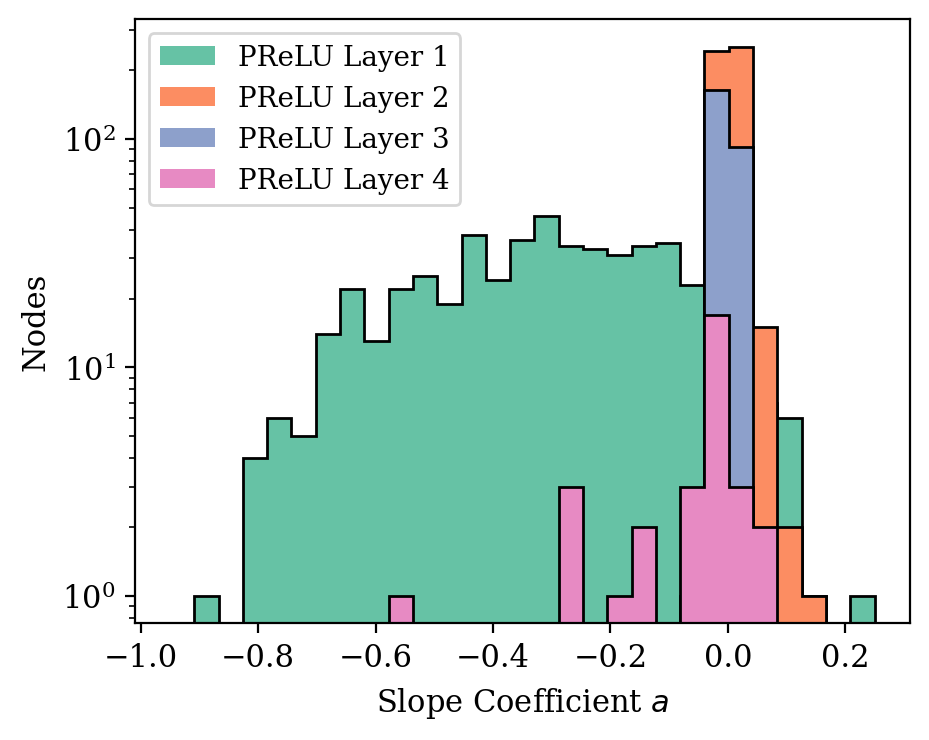

In [ ]:
model = create_model(polarization = True)
model.load_weights('models/rot_axis/i0_fou_pol_32.h5')

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set2.colors)

locs = [[0.05,40], [0.1,40], [0.04,]]

labels = ['N', 'bins', 'mean', 'std']
label_txt = ''
for label in labels:
    label_txt += label + '\n'

fig = plt.figure(figsize = (5,4), dpi = 200)
fig.set_facecolor('white')
ax = fig.add_subplot(111)
plt.xlabel('Slope Coefficient $a$')
plt.ylabel('Nodes')

for i, j in zip([7,10,13,16], range(1,5)):
    weights = model.layers[i].get_weights()

    bins = 50
    plt.hist(weights, bins = np.linspace(-.95,0.25,30), alpha = 1, label = 'PReLU Layer '+str(j))
    plt.hist(weights, bins = np.linspace(-.95,0.25,30), histtype = 'step', color = 'black', lw = 1)

    vals = [len(weights[0]), bins, np.mean(weights), np.std(weights)]
    val_txt = ''
    for val in vals:
        if type(val) != int:
            val = '%.3f' %val
        val_txt += str(val) + '\n'

    x = 0.04
    if j == 2:
        x = 0.7

    # plt.text(x, 0.65, label_txt, transform = ax.transAxes)
    # plt.text(x + 0.14, 0.65, val_txt, transform = ax.transAxes)

    # plt.title('PReLU Layer '+str(j))

plt.legend()
ax.set_yscale('log')

# Verification

In [ ]:
tilt = 23.4 * np.pi/180
rot_axis = np.array([np.cos(tilt),
                     2**-0.5 * np.sin(tilt),
                     -2**-0.5 * np.sin(tilt)])

print(rot_axis)
print(np.linalg.norm(rot_axis))

curve = earth_curves(rot_axis = rot_axis, incl = np.pi/2, fourier = True, clouds_ind = [0,0,1])

[ 0.91775463  0.28082597 -0.28082597]
1.0


In [ ]:
curve2 = noise_curves([curve[:,:,:,:2]], 1e4, polarization = True)
curve2 /= np.max(curve2)
curve2 = curve2.reshape((1,8,8,12))

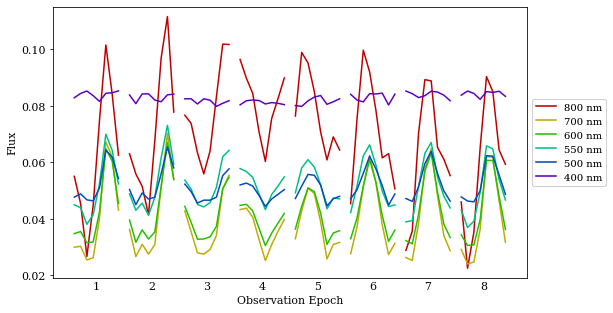

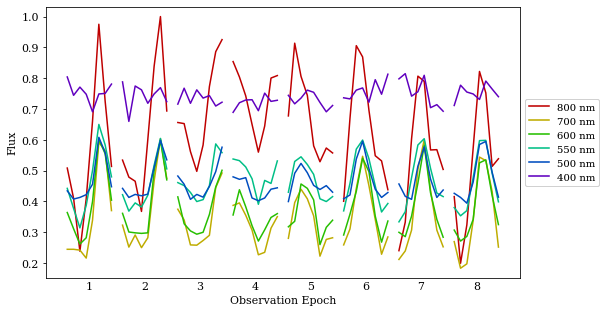

In [ ]:
plot_fluxes(curve[:,:,:,0])
plot_fluxes(curve2[0,:,:,::2])

In [ ]:
model = create_model(polarization = True)
model.load_weights('models/rot_axis/i90_fou_pol_32.h5')
pred = model.predict(curve2)
print(pred)
print(np.mean((pred - rot_axis)**2))

Model: "model_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
curves_input (InputLayer)    [(None, 8, 8, 12)]        0         
_________________________________________________________________
lambda_60 (Lambda)           (None, 8, 10, 12)         0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 8, 8, 16)          592       
_________________________________________________________________
lambda_61 (Lambda)           (None, 8, 11, 16)         0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 8, 4, 16)          1040      
_________________________________________________________________
flatten_30 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_120 (Dense)            (None, 512)               262

# Test that the Periodic Convolutions Work

In [ ]:
load_data(i = 90, axis_idx = range(32), flatten = False, maps = False,
          fourier = True, polarization = True, N_max = 1e4)

curves:  (286173, 8, 8, 12)
combos:  (286173, 4)
axes:    (286173, 3)


In [ ]:
# model = create_model(polarization = True)

model.fit(
    curves,
    axes,
    epochs = 100,
    batch_size=256,
    validation_split=0.1,
    callbacks=[keras.callbacks.EarlyStopping(patience=5)]
)

Epoch 1/100
1007/1007 [==============================] - 10s 10ms/step - loss: 0.0050 - val_loss: 0.0072
Epoch 2/100
1007/1007 [==============================] - 9s 9ms/step - loss: 0.0049 - val_loss: 0.0073
Epoch 3/100
1007/1007 [==============================] - 9s 9ms/step - loss: 0.0047 - val_loss: 0.0069
Epoch 4/100
1007/1007 [==============================] - 9s 9ms/step - loss: 0.0044 - val_loss: 0.0072
Epoch 5/100
1007/1007 [==============================] - 9s 9ms/step - loss: 0.0042 - val_loss: 0.0073
Epoch 6/100
1007/1007 [==============================] - 9s 9ms/step - loss: 0.0040 - val_loss: 0.0075
Epoch 7/100
1007/1007 [==============================] - 9s 9ms/step - loss: 0.0040 - val_loss: 0.0072
Epoch 8/100
1007/1007 [==============================] - 9s 9ms/step - loss: 0.0037 - val_loss: 0.0076


In [ ]:
input_shape = (8,8,12)

# # CREATE MODEL
c0 = keras.Input(shape = input_shape, name = 'curves_input')

c10 = Conv2D(filters = 16, kernel_size = (1, 3),
               padding = 'valid', activation = None,
               strides = (1,1))(c0)
c20 = Conv2D(filters = 16, kernel_size = (1, 4),
               padding = 'valid', activation = None,
               strides = (1,2))(c10)

# c10 = conv_curves(c0, kernel_size = 3, filters = 16)
# c20 = conv_curves(c10, kernel_size = 4, filters = 16, stride = 2)

c30 = Flatten()(c20)

x10 = Dense(512)(c30)
x11 = PReLU()(x10)
x12 = Dropout(0.15)(x11)

x20 = Dense(512)(x12)
x21 = PReLU()(x20)
x22 = Dropout(0.15)(x21)

x30 = Dense(256)(x22)
x31 = PReLU()(x30)
x32 = Dropout(0.15)(x31)

x60 = Dense(32)(x32)
x61 = PReLU()(x60)

x7 = Dense(3, name = 'final')(x61)
# make sure the output has a norm of 1
# x8 = Lambda(lambda  x: K.l2_normalize(x, axis=1))(x7)

model = keras.Model(
    inputs=[c0],
    outputs=[x7],
)

model.compile(optimizer = 'adam', loss='mse')
model.summary()

model.fit(
    curves,
    axes,
    epochs = 100,
    batch_size=256,
    validation_split=0.1,
    callbacks=[keras.callbacks.EarlyStopping(patience=2)]
)

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
curves_input (InputLayer)    [(None, 8, 8, 12)]        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 8, 6, 16)          592       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 8, 2, 16)          1040      
_________________________________________________________________
flatten_8 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 512)               131584    
_________________________________________________________________
p_re_lu_32 (PReLU)           (None, 512)               512       
_________________________________________________________________
dropout_24 (Dropout)         (None, 512)               0   